In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

import imblearn.pipeline
from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score,classification_report, roc_curve,roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# loading the dataset
df= pd.read_csv("cleaned_twitter_dataset.csv")
df.sample(10)

,clean_tweet,brand,clean_sentiment
5949,rt pepsicostage yesterday please check bag may ipad lock screen tell mine sxsw,unknown,2
1254,anyone using google checkins thru latitude? sxsw,unknown,2
4294,apple seems winning app world sxsw,apple,1
7423,another great panel pm hilton austin nik daftary left brain search google right brain search x sxsw,unknown,2
2829,cant help wonder apple sent extra ipad austinarea stores? sxsw,unknown,2
2762,walked line ipad bahahahaha! least block long fail sxsw,apple,0
182,like pm night line around block popup apple store selling ipads sxsw,apple,1
7259,google map mobile look awesomesxsw,google,1
246,here pic winning ipad! unsix sxsw cc link cont link,unknown,2
3777,outoftown douchebag selling new ipad sticker price link sxsw,unknown,2


In [3]:
# we only need the clean_tweet and the clean_sentiment columns
df= df[["clean_tweet", "clean_sentiment"]]
df.head()

,clean_tweet,clean_sentiment
0,g iphone hr tweeting riseaustin dead! need upgrade plugin station sxsw,0
1,know ? awesome ipadiphone app youll likely appreciate design also theyre giving free t sxsw,1
2,not wait ipad also sale sxsw,1
3,hope year festival isnt crashy year iphone app sxsw,0
4,great stuff fri sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8837 entries, 0 to 8836
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clean_tweet      8837 non-null   object
 1   clean_sentiment  8837 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 138.2+ KB


 ***
    The cleaned_twitter_dataset has no null values. The next step
    would be text vectorization before we begin modeling.

In [5]:
# value counts of sentiment column
df["clean_sentiment"].value_counts()

2    5358
1    2915
0     564
Name: clean_sentiment, dtype: int64

***
    This is our label column. The sentiments are not uniformly distributed
    and we would anticipate that we would have to deal with the imbalance 
    when modeling.
    

In [6]:
# seperate feature and target variables
X= df["clean_tweet"].values
y= df["clean_sentiment"].values

In [7]:
# split data into train and test 
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42, stratify= y)

In [8]:
# print the shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7069,) (1768,) (7069,) (1768,)


***
    The dataset is split into train and test set and we shall now move
    to modeling.

# 1. Modeling


    The goal is to build a model that can predict the tweet sentiment 
    with accuracy. 
    
    We shall begin by building a baseline model, and then subsequent models
    will capture the complexity of the dataset. 
    
    The following models will be explored:
        1. Multinomial Naive Bayes Classifier (Baseline Model)
        2. Support Vector Machine (SVM)
        3. Random Forest Classifier
        4. XGBoost Classifier
        5. Deep learning models:
            1. Simple RNN
            2. LSTM

## 1.1 Multinomial Naive Bayes Classifier (Baseline Model)

The Naive Bayes classifier is a simple yet powerful algorithm widely used in NLP.
It is based on Bayes’ Theorem and assumes that all features (words) are independent and contribute equally to the outcome.
Despite this simplifying assumption, it often performs remarkably well in sentiment analysis and text classification tasks.

Approach to adopt:
    
We will build a pipeline that performs two key steps:

#### TF–IDF Vectorization
Converts text into numerical features based on term frequency and inverse document frequency.

Filters out tokens that appear in fewer than 1% or more than 90% of documents.

Captures the most informative words in the corpus.

#### Multinomial Naive Bayes Classifier
Trains on the TF–IDF representations to predict sentiment classes.

Train Accuracy: 0.64
Test Accuracy: 0.64

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.65      0.19      0.29       583
           2       0.64      0.96      0.77      1072

    accuracy                           0.64      1768
   macro avg       0.43      0.38      0.35      1768
weighted avg       0.60      0.64      0.56      1768



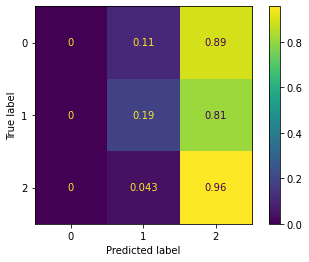

In [9]:
# Naive Bayes

# pipeline
nlp_pipe = Pipeline([('tfidf',TfidfVectorizer(min_df=0.01, max_df=0.9)),
                     ('nb', MultinomialNB())])

# fitting the model
nlp_pipe.fit(X_train, y_train)

# # prediction
y_pred_train = nlp_pipe.predict(X_train)
y_pred = nlp_pipe.predict(X_test)


# accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)


# accuracy and classification report
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

# confusion matrix
cfm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cfm).plot();

***
    The model has similar accuracy on the train and test, which is 
    relatively low. This might falsely indicate the model is not 
    overfitting. BUT;
    
    Looking at the classification report, the model is biased towards the
    majority class (2). It is not predicting anything on class 0. 
    
    The next step should be to address the class imbalance first to see if 
    the model performance improves. 

### 1.1.1 Addressing the class imbalance

To improve performance on underrepresented sentiment classes, we apply Random OverSampling on the training data only to avoid data leakage.

We then rebuild the pipeline to include the oversampling step between TF–IDF vectorization and classification.


Train Accuracy: 0.50
Test Accuracy: 0.48

Classification report:
               precision    recall  f1-score   support

           0       0.14      0.58      0.23       113
           1       0.45      0.48      0.46       583
           2       0.74      0.47      0.57      1072

    accuracy                           0.48      1768
   macro avg       0.44      0.51      0.42      1768
weighted avg       0.60      0.48      0.51      1768



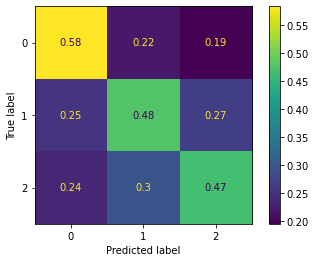

In [10]:
# Create a pipeline with TF-IDF, oversampling, and nb
nlp_pipe = imblearn.pipeline.Pipeline([('tfidf',TfidfVectorizer(min_df=0.01, max_df=0.9)),
                                       ('os', RandomOverSampler(random_state=42)),
                                       ('nb', MultinomialNB())])

# fitting the model
nlp_pipe.fit(X_train, y_train)

# prediction
y_pred_train = nlp_pipe.predict(X_train)
y_pred = nlp_pipe.predict(X_test)

# accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)


# accuracy and classification report
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

# confusion matrix
cfm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cfm).plot();

Accuracy: 0.48

Weighted Avg F1: 0.51

Observation:

Oversampling helped improve recall for minority classes, though overall accuracy decreased slightly.This trade-off is expected, as the model now better recognizes previously underrepresented sentiments.

Before we move to the other models, lets try to tune the hyperparameter to find the best parameters. 

### 1.1.2 Tuning the hyperparameters

We will perform a gridsearch using 5-fold cross validation. The tuning will
explore:

    - ngram ranges to capture single words,phrases and short expressions, 
    - varying min_df and max_df to control feature inclusion based on word
       frequency,and
    - alpha to balance bias–variance in probability estimates.

In [11]:
param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__max_df': [0.8, 0.9, 1.0],
              'tfidf__min_df': [0.01, 0.02],
              'nb__alpha': [0.1, 0.5, 1.0]}

grid_search = GridSearchCV(nlp_pipe,
                           param_grid,
                           cv=5,
                           scoring='f1_macro',
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1_macro: {:.2f}".format(grid_search.best_score_))

# Evaluate on test data
y_pred = grid_search.predict(X_test)
print("Test Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'nb__alpha': 1.0, 'tfidf__max_df': 0.8, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 1)}
Best F1_macro: 0.42
Test Accuracy: 0.48

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.58      0.23       113
           1       0.45      0.48      0.46       583
           2       0.74      0.47      0.57      1072

    accuracy                           0.48      1768
   macro avg       0.44      0.51      0.42      1768
weighted avg       0.60      0.48      0.51      1768



Observation: 
    
Best Parameters:

    tfidf__ngram_range: (1,1)
    tfidf__max_df: 0.8
    tfidf__min_df: 0.01
    nb__alpha: 1.0

Performance Summary:

    Best F1-macro: 0.42
    Test Accuracy: 0.48

While the model shows moderate performance, the imbalance between precision and recall across sentiment classes indicates room for improvement.

The next step is to explore Support Vector Machines (SVM)

## 1.2 Support Vector Machine (SVM)

The Support Vector Machine (SVM) is a robust and high-performing classifier for text data.

SVM aims to find the optimal hyperplane that maximizes the margin between sentiment classes, leading to improved generalization.

The steps to follow:
    
    Build initial SVM pipeline with TF-IDF features
    Build an SVM pipeline with TF-IDF features and Random Oversampling,
    Perform hyperparameter tuning and
    Evaluate model performance using classification metrics.

Train Accuracy: 0.74
Test Accuracy: 0.65

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.03      0.05       113
           1       0.61      0.30      0.41       583
           2       0.66      0.90      0.76      1072

    accuracy                           0.65      1768
   macro avg       0.62      0.41      0.41      1768
weighted avg       0.64      0.65      0.60      1768



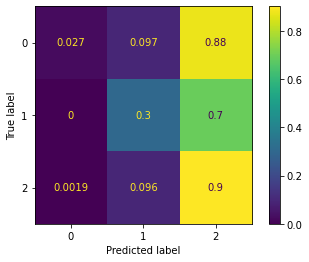

In [12]:
# SVM pipeline
svm_pipe = Pipeline([('tfidf', TfidfVectorizer(min_df=0.01, max_df=0.8)),
                     ('svm', SVC(random_state=42))])

# Train model
svm_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = svm_pipe.predict(X_train)
y_pred = svm_pipe.predict(X_test)

# Evaluation
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot();


    The SVM model achieves 74% training accuracy and 65% test accuracy,
    showing moderate generalization.
    However, performance across classes is imbalanced in that the model 
    performs well on the majority class (recall = 0.90) but poorly on 
    minority classes (recall = 0.03).
    This indicates class imbalance, which motivates applying 
    RandomOverSampler to improve fairness across categories.

### 1.2.1 SVM with Oversampling to Handle Class Imbalance

Train Accuracy: 0.77
Test Accuracy: 0.58

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.35      0.25       113
           1       0.50      0.56      0.53       583
           2       0.73      0.60      0.66      1072

    accuracy                           0.58      1768
   macro avg       0.47      0.51      0.48      1768
weighted avg       0.62      0.58      0.59      1768



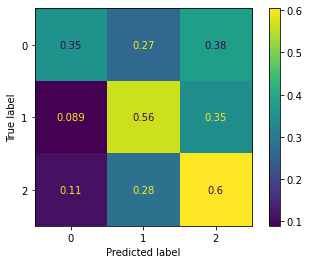

In [13]:
# SVM pipeline
svm_pipe = imblearn.pipeline.Pipeline([('tfidf', TfidfVectorizer(min_df=0.01, max_df=0.8)),
                                       ('os', RandomOverSampler(random_state=42)),
                                       ('svm', SVC(random_state=42))])

# Train model
svm_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = svm_pipe.predict(X_train)
y_pred = svm_pipe.predict(X_test)

# Evaluation
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot();

 
    After applying RandomOverSampler, the model shows improvement in 
    performance for the minority class 0 where both recall (0.03-0.35) 
    and F1-score(0.05-0.25) increased. 
    
    However, the overall test accuracy (0.58) remains lower than the 
    training accuracy (0.77), suggesting some degree of overfitting.
    
    While the model now performs more fairly across classes, further 
    improvements could be achieved through hyperparameter tuning which 
    is the next step before exploring tree-based ensemble models that 
    handle class imbalance more effectively.

### 1.2.2 SVM - Hyperparameter tuning

We will perfrom a gridsearch using 5-fold cross-validation. The tuning will explore the: 

    kernel types (linear, rbf, poly),
    regularization strengths (C), and 
    kernel coefficients (gamma).
    
The goal was to find the best combination of parameters that balance bias and variance while improving generalization.



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best F1_macro: 0.50
Test Accuracy: 0.58

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.35      0.25       113
           1       0.50      0.56      0.53       583
           2       0.73      0.60      0.66      1072

    accuracy                           0.58      1768
   macro avg       0.47      0.51      0.48      1768
weighted avg       0.62      0.58      0.59      1768



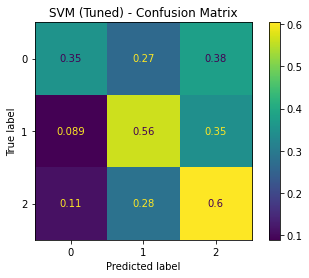

In [14]:
# parameter grid
param_grid = {'svm__C': [0.1, 1, 10],
              'svm__kernel': ['linear', 'rbf', 'poly'],
              'svm__gamma': ['scale', 'auto']}

# Set up GridSearchCV
svm_grid_search = GridSearchCV(
    svm_pipe,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2)

# Fit grid search
svm_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", svm_grid_search.best_params_)
print("Best F1_macro: {:.2f}".format(svm_grid_search.best_score_))

# Evaluate on test data
best_svm = svm_grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
print("Test Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot()
plt.title("SVM (Tuned) - Confusion Matrix")
plt.show()

Best Parameters:

    'svm__C': 1,
    'svm__gamma': 'scale',
    'svm__kernel': 'rbf'
Best F1_macro: 0.50
    
Performance remained consistent with the oversampled model(accuracy = 0.58)
with stronger results for the majority class but modest gains for minority classes.

While SVM assume a straight-line relationship between features and classes, tree-based models can capture non-linear relationships.

We’ll explore:

    Random Forest- An ensemble of decision trees that reduces variance by
    averaging predictions.
    XGBoost- A gradient boosting model that sequentially learns from 
    misclassified samples, improving accuracy.

Tree-based models are less sensitive to outliers and can reveal complex feature interactions that linear models might miss.

## 1.3 Random Forest Classifier

We will begin by training a Random Forest classifier using 200 estimators and no depth limit to assess its initial performance before addressing class imbalance or hyperparameter tuning.

Train Accuracy: 92.25
Test Accuracy: 63.69

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.11      0.16       113
           1       0.54      0.44      0.48       583
           2       0.68      0.80      0.74      1072

    accuracy                           0.64      1768
   macro avg       0.52      0.45      0.46      1768
weighted avg       0.61      0.64      0.62      1768



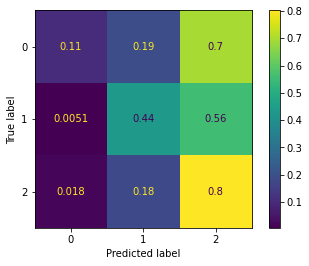

In [15]:
# Random Forest pipeline
rf_pipe = Pipeline([('tfidf', TfidfVectorizer(min_df=0.01, max_df=0.8)),
                    ('rf', RandomForestClassifier(n_estimators=200,max_depth=None,random_state=42))])

# Train model
rf_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = rf_pipe.predict(X_train)
y_pred = rf_pipe.predict(X_test)

# Evaluation
train_acc = accuracy_score(y_train, y_pred_train)*100
test_acc = accuracy_score(y_test, y_pred)*100

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot();

***
    The model achieves a training accuracy of 92.25% and
    a test accuracy of 63.69%, indicating overfitting.
    
    While the model performs reasonably well on the majority class 2,
    it struggles with minority classes, especially class 0, as seen from 
    the low recall.
    
    This suggests that class imbalance and parameter optimization need to
    be addressed to improve generalization and fairness across classes.

### 1.3.1 Handling class imbalance

Train Accuracy: 0.90
Test Accuracy: 0.60

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.27      0.23       113
           1       0.51      0.51      0.51       583
           2       0.70      0.68      0.69      1072

    accuracy                           0.60      1768
   macro avg       0.47      0.48      0.48      1768
weighted avg       0.61      0.60      0.60      1768



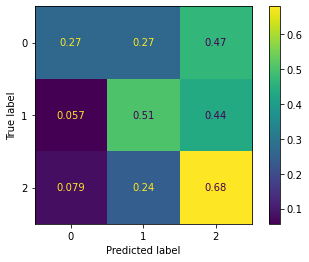

In [16]:
# Random Forest pipeline
rf_pipe = imblearn.pipeline.Pipeline([('tfidf', TfidfVectorizer(min_df=0.01, max_df=0.8)),
                                      ('os', RandomOverSampler(random_state=42)),
                                      ('rf', RandomForestClassifier(n_estimators=200,max_depth=None,random_state=42))])

# Train model
rf_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = rf_pipe.predict(X_train)
y_pred = rf_pipe.predict(X_test)

# Evaluation
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot();

***
    The test accuracy reduces slightly(63% - 60%), but the recall for 
    class 0 improves. 
    
    There is a slight drop in overall generalization due to oversampling.

    Macro F1 (0.48) indicates more balanced performance across all classes.

### 1.3.2 Random_forest - Hyperparameter tuning

The tuning focuses on key parameters including the number of trees (n_estimators), tree depth (max_depth), split criteria (criterion), and sampling constraints.

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Random Forest Parameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': None, 'rf__criterion': 'entropy'}
Best F1_macro: 0.48
Test Accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.45      0.27       113
           1       0.50      0.54      0.52       583
           2       0.73      0.60      0.66      1072

    accuracy                           0.57      1768
   macro avg       0.47      0.53      0.48      1768
weighted avg       0.62      0.57      0.59      1768



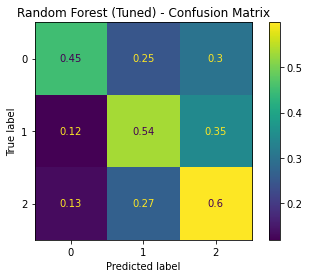

In [17]:
# hyperparameter tuning

# hyperparameter grid
rf_param_grid = {'rf__n_estimators': [100, 200, 300],
                 'rf__max_depth': [10, 20, 30, None],
                 'rf__min_samples_split': [2, 5, 10],
                 'rf__min_samples_leaf': [1, 2, 4],
                 'rf__max_features': ['sqrt', 'log2'],
                'rf__criterion':['gini', 'entropy']}

rf_grid = RandomizedSearchCV(rf_pipe,
                             rf_param_grid,
                             scoring='f1_macro',
                             cv=5,
                             verbose=2,
                             n_jobs=-1)


# Fit model
rf_grid.fit(X_train, y_train)

# Best parameters
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best F1_macro: {:.2f}".format(rf_grid.best_score_))

# Evaluate on test data
best_rf = rf_grid.best_estimator_
y_pred = best_rf.predict(X_test)
print("Test Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot()
plt.title("Random Forest (Tuned) - Confusion Matrix")
plt.show()


    The test accuracy has been dropping since the initial random forest model(63%-60%-57%). Although this 
    is a trade off with increased performance for the minority class, which is reasonable. 
    
    The F1-macro has remained constant at 48% indicating a slightly moderate balance between all the classes.
    
    We shall now explore XGBoost to see if the performance improves.

## 1.4 XGBoost Classifier

Train Accuracy: 0.82
Test Accuracy: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.04      0.08       113
           1       0.54      0.39      0.45       583
           2       0.67      0.83      0.74      1072

    accuracy                           0.63      1768
   macro avg       0.49      0.42      0.42      1768
weighted avg       0.60      0.63      0.60      1768



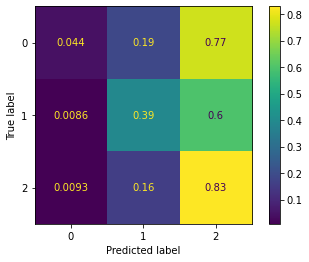

In [18]:
# XGBoost pipeline
xgb_pipe = Pipeline([('tfidf', TfidfVectorizer(min_df=0.01, max_df=0.9)),
                     ('xgb', XGBClassifier(n_estimators=300,
                                           learning_rate=0.1,
                                           max_depth=6,
                                           subsample=0.8,
                                           colsample_bytree=0.8,
                                           random_state=42,
                                           use_label_encoder=False,
                                           eval_metric='mlogloss'))])

# Train model
xgb_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = xgb_pipe.predict(X_train)
y_pred = xgb_pipe.predict(X_test)

# Evaluation
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot();


    The train and test accuracy shows the model fails to generalize well. Looking at the classification report, the model
    is baised towards the majority class, indicating a class imbalance which we shall correct next.

### 1.4.1 XGBoost- handling class imbalance

Train Accuracy: 0.77
Test Accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.41      0.24       113
           1       0.50      0.56      0.53       583
           2       0.74      0.59      0.66      1072

    accuracy                           0.57      1768
   macro avg       0.47      0.52      0.48      1768
weighted avg       0.63      0.57      0.59      1768



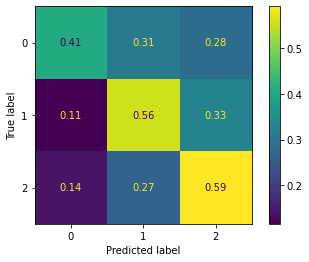

In [19]:
# pipeline
xgb_pipe = imblearn.pipeline.Pipeline([('tfidf', TfidfVectorizer(min_df=0.01, max_df=0.9)),
                                       ('os', RandomOverSampler(random_state=42)),
                                       ('xgb', XGBClassifier(objective='multi:softprob',
                                                             eval_metric='mlogloss',
                                                             random_state=42,
                                                             use_label_encoder=False))])

# Train model
xgb_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = xgb_pipe.predict(X_train)
y_pred = xgb_pipe.predict(X_test)

# Evaluation
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot();


    as expected, after random oversampling, the model's accuracy declines. On the good side, the precision, recall and 
    f1-score for the minority class has improved. Lets try tuning the hyperparameters to see if it improves further:

### 1.4.2 XGBoost- Hyperparameter tuning

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost Parameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 200, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 1.0}
Best F1_macro: 0.47
Test Accuracy: 0.56

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.42      0.25       113
           1       0.50      0.52      0.51       583
           2       0.73      0.59      0.65      1072

    accuracy                           0.56      1768
   macro avg       0.47      0.51      0.47      1768
weighted avg       0.62      0.56      0.58      1768



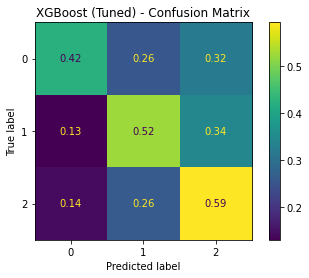

In [20]:
xgb_param_grid = {'xgb__n_estimators': [100, 200, 300],
                  'xgb__learning_rate': [0.01, 0.05, 0.1],
                  'xgb__max_depth': [4, 6, 8],
                  'xgb__subsample': [0.7, 0.8, 1.0],
                  'xgb__colsample_bytree': [0.7, 0.8, 1.0]}

# Randomized search for XGBoost
xgb_search = RandomizedSearchCV(
    xgb_pipe,
    xgb_param_grid,
    n_iter=10,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit model
xgb_search.fit(X_train, y_train)

# Best parameters
print("Best XGBoost Parameters:", xgb_search.best_params_)
print("Best F1_macro: {:.2f}".format(xgb_search.best_score_))

# Evaluate on test data
best_xgb = xgb_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print("Test Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot()
plt.title("XGBoost (Tuned) - Confusion Matrix")
plt.show()


    On tuning the hyperparameters, the test accuracy drops by 1%, same as the f1_macro. The model although shows
    improved performance on the minority class. 

## 1.5 Conclusion on Machine Learning Models   

In [26]:
from IPython.display import display, Markdown

# Create a Markdown table
table = """
| Model         | Best F1-Macro | Test Accuracy | Metric           |
|---------------|---------------|---------------|------------------|
| NB            | 0.42          | 0.48          |                  |
| SVM           | 0.50          | 0.58          | **Best F1-macro** |
| Random_Forest | 0.48          | 0.57          |                  |
| XGBoost       | 0.47          | 0.56          |                  |
"""

# Display the Markdown table
display(Markdown(table))


| Model         | Best F1-Macro | Test Accuracy | Metric           |
|---------------|---------------|---------------|------------------|
| NB            | 0.42          | 0.48          |                  |
| SVM           | 0.50          | 0.58          | **Best F1-macro** |
| Random_Forest | 0.48          | 0.57          |                  |
| XGBoost       | 0.47          | 0.56          |                  |


*****
    Among all models, SVM achieved the best F1-macro score (0.50), indicating superior balance in precision and recall 
    across classes and the highest test accuracy (0.59), suggesting it predicted the majority class more effectively.
    
    Although Naive Bayes and XGBoost performed reasonably, their F1 and accuracy scores were comparatively lower, showing 
    limited ability to generalize across all sentiment categories.
    
    Given that F1-macro provides a more reliable measure for imbalanced datasets by emphasizing performance across all 
    classes, the SVM model is selected as the best-performing and most suitable model for deployment.

## 1.6 Deploying the best model

In [22]:
import pickle

In [23]:
filename = 'trained_model.sav'
pickle.dump(svm_grid_search, open(filename, 'wb'))

In [24]:
# loading the saved model
loaded_model = pickle.load(open('trained_model.sav', 'rb'))

In [32]:

import gradio as gr
import joblib
import re

# Load model
model = joblib.load('trained_model.sav')

def preprocess_tweet(tweet):
    """
    Clean and preprocess tweet text
    """
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Remove user mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove hashtag symbol but keep the word
    tweet = re.sub(r'#', '', tweet)
    
    # Remove special characters and numbers (keep letters and spaces)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    
    # Remove extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet)
    
    # Convert to lowercase and strip
    tweet = tweet.lower().strip()
    
    return tweet

def classify(tweet):
    """
    Classify tweet sentiment with preprocessing
    """
    if not tweet.strip():
        return "Please enter a tweet"
    
    # Preprocess the tweet
    cleaned_tweet = preprocess_tweet(tweet)
    
    # If preprocessing removes everything, return error
    if not cleaned_tweet:
        return "Tweet has no valid text after preprocessing"
    
    # Predict using cleaned tweet (no probabilities)
    pred = model.predict([cleaned_tweet])[0]
    
    return str(pred)

# Create Gradio interface
demo = gr.Interface(
    fn=classify,
    inputs=gr.Textbox(
        lines=3, 
        placeholder="Enter a tweet here... (emojis, URLs, @mentions will be cleaned)",
        label="Tweet"
    ),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="🐦 Tweet Sentiment Classifier",
    description="Enter any tweet to analyze its sentiment. The model automatically cleans URLs, mentions, hashtags, and special characters.",
    theme=gr.themes.Soft()
)

# Launch the interface
demo.launch(share=True)  # Creates public link!

ImportError: cannot import name 'TypeIs' from 'typing_extensions' (C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\typing_extensions.py)